**CASE STUDY Auto-Taggler für Programmierfragen**



**I. Wie lautet die Aufgabe? Was soll gelöst werden?**


**Situation:** Auf der Community-Pattform gibt es ein Frage-&-Antwort-Modul. Damit Experten leichter bei Fragen in ihrem Gebiet helfen können, sollen die Fragen automatisiert mit Tags versehen werden.

**Aufgabe:** Entwickle den Protoypen eines KI-Modells, um die Machbarkeit der Fallstudie zu evaluieren. Als Datensatz wird dazu mit öffentlich verfügbaren Datensätzen aus StackOverflow gearbeitet. Dabei sollen anhand der Überschriften und/ oder der Fragentexte die zugewiesenen Tags vorhergesagt werden.

**II. Wie sehen die Daten aus?**

- Die von StackOverflow zu Verfügung gestellten Daten (Fragen & Antworten) bestehen aus einem Format mit 6 Spalten: "ID", "OwnerUserID", "Creation Date", "Score", "Title" und "Body". In "Title" sind die Fragen, in "Body" die Antworten gespeichert.
- Die Tags bestehen aus einem Format mit 2 Spalten: "ID" und "Tag"
- Über die Spalte "ID" sind beide Tabellen miteinander verknüft und somit den Fragen & Antworten Tags zugeordnet.
- In der Regel existieren für eine "ID" mehrere Tags. Die "IDs" sind dafür über mehrere Zeilen verteilt.

Der folgende Ausschnitt gibt einen Blick in die Daten:


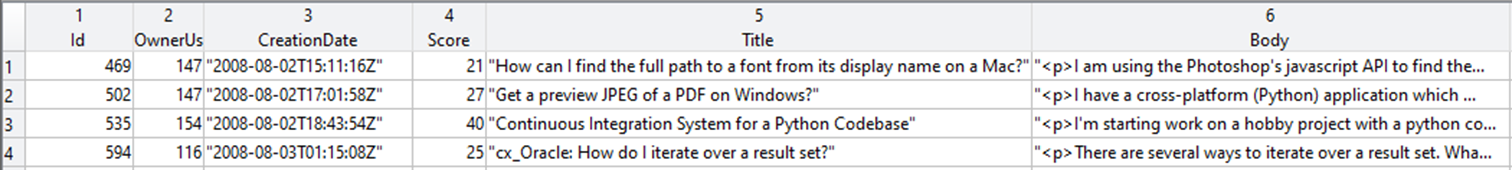

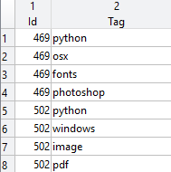

**III. Wie ist das Vorgehen bei der Lösung der Fallstudie?**

Aufbauend auf der Struktur der Daten werden - in einem ersten Schritt - folgende Vereinfachungen vorgenommen:

1.   Aus den Data von StackOverflow werden nur "ID" und "Title" (Fragen) behalten. Die Daten "Body" (Antworten) könnten jedoch jederzeit wieder zum Modell hinzugefügt werden, und so die Datenbasis des Modells erweitert werden.
2.   Aus den Data von StackOverflorw werden nur die Daten der ersten 5000 Einträge (Zeilen) behalten. Weitere Einträge (Zeilen) könnten jederzeit zum Modell hinzugefügt werden.
3.   In der Regel gibt es zu jeder "ID" und damit auch zu jeder Frage & Antwort ("Title" & "Body") mehrere Tags. Dies ist - aus meiner Sicht - die größter Herausforderung bei der Erstellung eines Prototypen.

In einem zweiten Schritt werden daher für die Tags folgende Vereinfachungen vorgenommen und diese weiter transformiert:


*   Alle Einträge mit dem Tag "Python" werden entfernt. Hintergrund ist, dass dieser Tag mit einem Beitrag von ca. 33 % an (fast) jeder Frage ("Title") beteiligt ist. Daher ist der Informationsgehalt des Tags "Python" gering.
*   Um nicht mehrere Klassen (Tags) gleichzeitig vorhersagen zu müssen, werden zunächst die 10 am häufigsten vorkommenden Tags genommen und dem Label "1" zugeordnet, alle anderen Tags werden dem Label "0" zugeornet. Auf diese Weise vereinfacht sich das Klassifizierungsproblem zunächst sehr stark.
*   Die 10 am häufigsten vorkommenden Tags sind: "django", "linux", "windows", "intention", "xml", "validation", "database", "unicode", "php" und "osx".
*   Ein solches Modell würde also nicht einen einzelnen Tag vorhersagen, sondern nur, ob eine Frage zur Klasse der 10 am häufigsten vorkommenden Tags gehört und diese dann ausgeben.
*   Nach einem ersten Testlauf mit diesem binären Klassifikator werden wir weiter Modelle betrachten.

Nach diese Transformation sehen die ersten Fragen wie folgt aus (vgl. II):




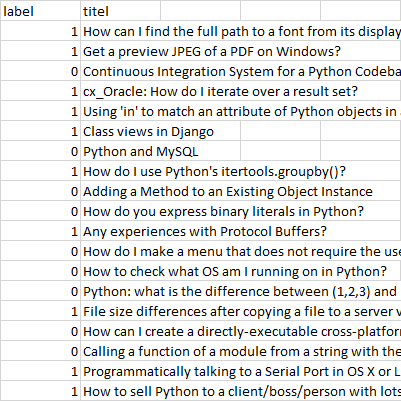

Beispiel: Der ersten Eintrag "How can I finde the full path to a front from its display" wird mit dem Label 1 versehen, da diese Frage den Tag "osx" einhält.

Mit diesen Vortransformationen können jetzt (einfache) NLP Modelle an die Daten gefittet werden.

**1. Datein einlesen**


In [ ]:
from google.colab import files

uploaded = files.upload()


import pandas
data5000 = pandas.read_excel("data5000.xlsx")

Saving data100.xlsx to data100 (1).xlsx
Saving data5000.xlsx to data5000 (1).xlsx


In [ ]:
data5000.head()

,label,titel
0,1,How can I find the full path to a font from it...
1,1,Get a preview JPEG of a PDF on Windows?
2,0,Continuous Integration System for a Python Cod...
3,1,cx_Oracle: How do I iterate over a result set?
4,1,Using 'in' to match an attribute of Python obj...


Die Daten haben 1113 mal das Label 1 und 3387 mal das Label 0. Ein naives ML Modell, das immer die Klasse 0 vorraussagt, würde eine Accuracy von 77,7% (=3387/5000) erzielen.

2. **Bag Of Worlds Model**

Das erste NLP Model ist ein Bag of Worlds Model. Hierbei wird aus einem Satz nur die Häufigkeit für das Auftreten einzelner Wörter extrahiert. Oft genügt dies schon, insbesondere wenn besondere Schlüsselwörter vorkommen. Nachteilig an dem Bag of Worlds Modell ist, das Informationen über die Reihenfolge der Wörter verloren geht. Hierfür wird zunächst aus sklearn die Routine CountVectorizer verwendet. Zunächst werden die Daten in ein Trainings- und Testset geteilt. 25% Testdaten ist eine gänge Wahl und sollte realistische Ergebnisse ermöglichen. Setze den random_state auf z. B. 1000 um Reproduzierbarkeit zu gewährlesiten. Als erstes ML Modell wird eine einfache Logistische Regression gefittet.


2.1 Logistische Regression

In [ ]:
sentences = data5000['titel'].values
labels = data5000['label'].values

In [ ]:
from sklearn.model_selection import train_test_split

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.25, random_state=1000)



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test = vectorizer.transform(sentences_test)

X_train.shape

(3749, 4215)

Das Vokabular hat 4215 Einträge. Für jedes Beispiel gibt es also einen Vektor mit 4215 Einträgen mit der einfachen Häufigkeit aller Wörter. Der Vektor jedes Beispiels ist dünn besetzt, enhält also hauptsächlich Nulleinträge.

In [ ]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
scoretrain = classifier.score(X_train, y_train)
scoretest = classifier.score(X_test, y_test)

print("Accuracy:", scoretrain)
print("Accuracy:", scoretest)

Accuracy: 0.9402507335289411
Accuracy: 0.8928


Die Güte der Logistischen Regression erscheint sehr hoch. Auf jeden Fall übersteigt sie die des naiven ML Modells mit 77,7% (siehe oben).

2.2 Einfaches NN

Als zweites ML Modell wird ein faches NN gefittet. Die Dimension der Inputschicht entspricht der Größe des Vokabular bzw. der Länge der Vektoren in X_train. Das Modell enthält nur 1 Zwischenschicht. Für die Ausgabeschicht wird die sigmoid Funktion verwendet, da es sich um ein binäres Klassifikationsproblem handelt. Als Lossfunction wird die binäre Kreuzentropie verwendet. Alle weitere Parameter sind "standardmäßig". Als Validierungset verwenden wir hier zunächst die Testdaten. Mit einem größeren Datensatz sollte aus den Trainingsdaten ein eigener Validierungsdatensatz gewonnen werden, und die Testdaten ausschließlich für den finalen Test verwenden werden.

In [ ]:
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers

In [ ]:
model = models.Sequential()
model.add(layers.Dense(10, input_dim=X_train.shape[1], activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                42160     
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 42171 (164.73 KB)
Trainable params: 42171 (164.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    batch_size=32
)

Epoch 1/100
118/118 [==============================] - 1s 4ms/step - loss: 6.4708e-04 - accuracy: 0.9997 - val_loss: 1.8101 - val_accuracy: 0.8216
Epoch 2/100
118/118 [==============================] - 1s 5ms/step - loss: 6.4656e-04 - accuracy: 0.9997 - val_loss: 1.8205 - val_accuracy: 0.8224
Epoch 3/100
118/118 [==============================] - 2s 16ms/step - loss: 6.4519e-04 - accuracy: 0.9997 - val_loss: 1.8271 - val_accuracy: 0.8240
Epoch 4/100
118/118 [==============================] - 1s 3ms/step - loss: 6.4445e-04 - accuracy: 0.9997 - val_loss: 1.8391 - val_accuracy: 0.8224
Epoch 5/100
118/118 [==============================] - 2s 18ms/step - loss: 6.4293e-04 - accuracy: 0.9997 - val_loss: 1.8501 - val_accuracy: 0.8232
Epoch 6/100
118/118 [==============================] - 1s 6ms/step - loss: 6.4154e-04 - accuracy: 0.9997 - val_loss: 1.8616 - val_accuracy: 0.8232
Epoch 7/100
118/118 [==============================] - 1s 6ms/step - loss: 6.4108e-04 - accuracy: 0.9997 - val_loss:

In [ ]:
_, train_accuracy = model.evaluate(X_train, y_train)
_, test_accuracy = model.evaluate(X_test, y_test)
print(f'Training accuracy: {train_accuracy:.4f}')
print(f'Testing accuracy: {test_accuracy:.4f}')

40/40 [==============================] - 0s 2ms/step - loss: 2.6273 - accuracy: 0.8176
Training accuracy: 0.9997
Testing accuracy: 0.8176


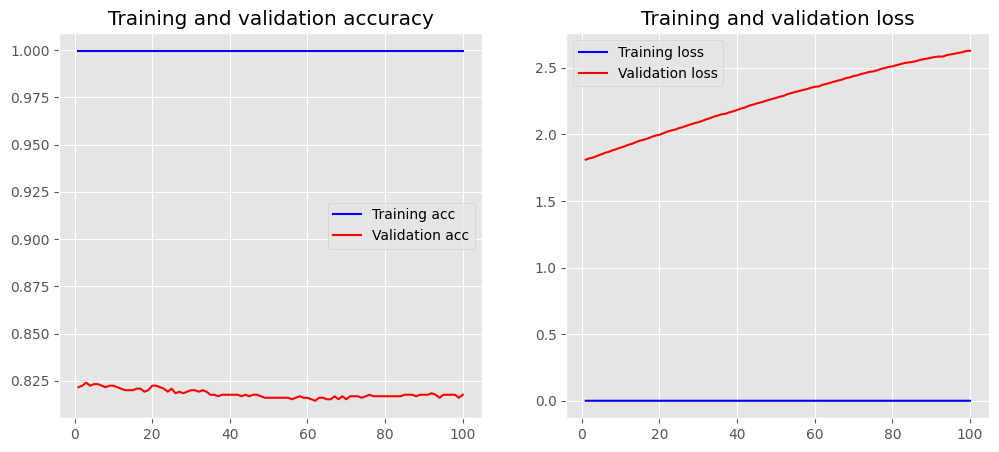

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

Das NN Modell ist unbrauchbar

**3. World Embeddings**

Als nächstes betrachten wir World Embeddings. Diese sind Standard im NLP. Diese Methode stellt Wörter als dichte Wortvektoren dar, die in der Regel während des Trainings eines Modell (z.B. eines NN) mittrainiert werden. Dies bedeutet, dass die Worteinbettungen mehr Informationen in weniger Dimensionen sammeln. Dieser geometrische Raum heißt dann Embedding Space. Für ein World Embedding gibt es zwei Möglichkeiten. Eine Möglichkeit besteht darin, die Worteinbettungen während des Trainings des neuronalen Netzwerks zu erlenen. Keras bietet hierfür Embedding Layers (siehe 3.1). Die andere Möglichkeit besteht darin, vorab trainierte Worteinbettungen zu verwenden (siehe 3.2), die direkt im Modell verwendet werden.

3.1 Embedding Layer

Als ersten verwenden wir einen Tokenizer. Diese vektorisiert einen Text in  eine Liste von Ganzzahlen. Die Größe des Vokabulars wird dabei auf 5000 begrenzt. Die Indizierung wird dabei nach der Häufigkeit für das Auftreten eines Wortes im Text vorgenommen. So taucht z. B. das Wort "python" am häufigsten auf und erhält daher den Index 1.

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

print(sentences_train[2])
print(X_train[2])

How do I upgrade python 2.5.2 to python 2.6rc2 on ubuntu linux 8.04?
[5, 12, 8, 1449, 1, 34, 156, 34, 4, 1, 34, 2090, 18, 659, 190, 341, 1131]


Die Textsequenzen haben in der Regel unterschiedliche Längen. Damit diese von einem neuronalen Netz verarbeitet werden können, wird für jeden Eintrag die vektorisierte Textsequenz mit Nullen aufgefüllt. Die Länge der Sequenz wird hier auf 100 festgelegt.

In [ ]:
from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, padding='post', maxlen=100)
X_test = pad_sequences(X_test, padding='post', maxlen=100)

print(sentences_train[2])
print(X_train[2])

How do I upgrade python 2.5.2 to python 2.6rc2 on ubuntu linux 8.04?
[   5   12    8 1449    1   34  156   34    4    1   34 2090   18  659
  190  341 1131    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


Jetzt fügen wir in das neuronale Netz eine Embeddingschicht ein. Diese hat 3 Parameter:
1. imput_dim = Länge des Vokular
2. output_dim = Länge des Embedding Vektors
3. input_length = Länger Sequenz

Die Länge des Vokabular ist 5000 (+1), die Länge des Embedding Vektors wählen wir zunächst auf 50 und die Länge der Sequenz ist 100.

Der weitere Aufbau sowie das Trainieren des neuronalen Netzes bleibt wie gehabt.

In [ ]:
model = models.Sequential()
model.add(
    layers.Embedding(
        input_dim=len(tokenizer.word_index) + 1,
        output_dim=50,
        input_length=100
    )
)
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
    batch_size=10
)

In [ ]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=10)

Epoch 1/20
375/375 [==============================] - 8s 18ms/step - loss: 0.5094 - accuracy: 0.7754 - val_loss: 0.4427 - val_accuracy: 0.7768
Epoch 2/20
375/375 [==============================] - 7s 19ms/step - loss: 0.3623 - accuracy: 0.8544 - val_loss: 0.4018 - val_accuracy: 0.8680
Epoch 3/20
375/375 [==============================] - 7s 20ms/step - loss: 0.2601 - accuracy: 0.9192 - val_loss: 0.4049 - val_accuracy: 0.8744
Epoch 4/20
375/375 [==============================] - 7s 19ms/step - loss: 0.1864 - accuracy: 0.9557 - val_loss: 0.4407 - val_accuracy: 0.8712
Epoch 5/20
375/375 [==============================] - 9s 23ms/step - loss: 0.1374 - accuracy: 0.9792 - val_loss: 0.4693 - val_accuracy: 0.8696
Epoch 6/20
375/375 [==============================] - 11s 28ms/step - loss: 0.1024 - accuracy: 0.9907 - val_loss: 0.4768 - val_accuracy: 0.8640
Epoch 7/20
375/375 [==============================] - 7s 20ms/step - loss: 0.0801 - accuracy: 0.9952 - val_loss: 0.5255 - val_accuracy: 0.863

118/118 [==============================] - 2s 15ms/step - loss: 0.0177 - accuracy: 0.9973
Training Accuracy: 0.9973
40/40 [==============================] - 1s 37ms/step - loss: 0.8323 - accuracy: 0.8640
Testing Accuracy: 0.8640


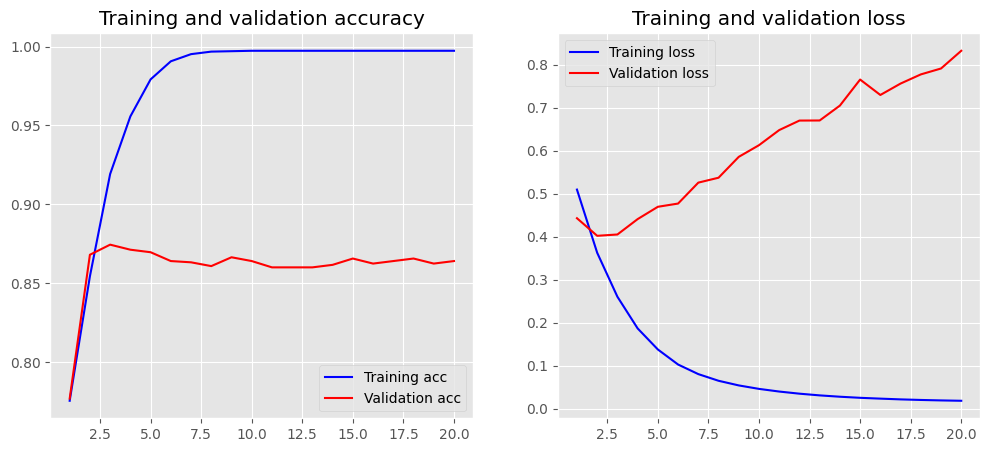

In [ ]:
_, train_accuracy = model.evaluate(X_train, y_train)
print(f'Training Accuracy: {train_accuracy:.4f}')
_, test_accuracy = model.evaluate(X_test, y_test)
print(f'Testing Accuracy: {test_accuracy:.4f}')
plot_history(history)

Das NN überfittet ab der 3 Epoche. Die Accuracy das Modell beträgt dann ca. 87% auf den Testdaten. Auf jeden Fall übersteigt sie die des naiven ML Modells mit 77,7% (siehe oben).

3.1 Mit PoolingLayer

Kleine Variante zu oben. Ein Pooling Layer reduziert die Dimension des Embedding Vektors z.B. imdem nur der maximale Wert (GlobalMaxPool1D) oder der duchschnittliche Wert (GlobalAveragePooling1D) des Embedding Vektors verwendet wird.

Epoch 1/20
375/375 [==============================] - 7s 15ms/step - loss: 0.4762 - accuracy: 0.8031 - val_loss: 0.3844 - val_accuracy: 0.8688
Epoch 2/20
375/375 [==============================] - 7s 20ms/step - loss: 0.2830 - accuracy: 0.8933 - val_loss: 0.3155 - val_accuracy: 0.8944
Epoch 3/20
375/375 [==============================] - 7s 19ms/step - loss: 0.1776 - accuracy: 0.9288 - val_loss: 0.3412 - val_accuracy: 0.8976
Epoch 4/20
375/375 [==============================] - 5s 14ms/step - loss: 0.1113 - accuracy: 0.9645 - val_loss: 0.3822 - val_accuracy: 0.8936
Epoch 5/20
375/375 [==============================] - 10s 28ms/step - loss: 0.0668 - accuracy: 0.9835 - val_loss: 0.4353 - val_accuracy: 0.8888
Epoch 6/20
375/375 [==============================] - 9s 25ms/step - loss: 0.0402 - accuracy: 0.9925 - val_loss: 0.4819 - val_accuracy: 0.8832
Epoch 7/20
375/375 [==============================] - 5s 15ms/step - loss: 0.0247 - accuracy: 0.9965 - val_loss: 0.5366 - val_accuracy: 0.875

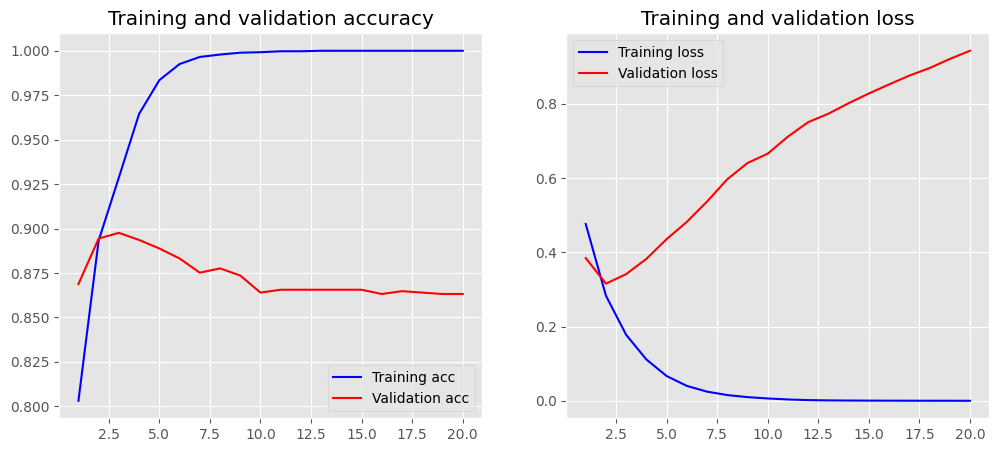

In [ ]:
model = models.Sequential()
model.add(
    layers.Embedding(
        input_dim=len(tokenizer.word_index) + 1,
        output_dim=50,
        input_length=100
    )
)
model.add(layers.GlobalMaxPool1D())
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_test, y_test),
    batch_size=10
)

_, train_accuracy = model.evaluate(X_train, y_train)
print(f'Training Accuracy: {train_accuracy:.4f}')
_, test_accuracy = model.evaluate(X_test, y_test)
print(f'Testing Accuracy: {test_accuracy:.4f}')
plot_history(history)

Das NN überfittet wieder ab der 3 Epoche. Die Accuracy das Modell beträgt dann ca. 90% auf den Testdaten. Diese ist eine leichte Verbesserung zum NN ohne Pooling Layer mit ca. 87%. Auf jeden Fall übersteigt sie die des naiven ML Modells mit 77,7% (siehe oben).

3.2 Pretrained Word Embeddings

Als letztes Modell versuchen wir ein vortrainierte Embeddingschicht. Dafür verwenden wir GloVe (Global Vectors for Word Representation) entwickelt von der Stanford NLP Group.


In [ ]:
import requests
import zipfile

def get_data(url, fn):
  response = requests.get(url)
  f = open(fn, 'wb')
  f.write(response.content)
  f.close()

def extract_data(fn):
  with zipfile.ZipFile(fn, 'r') as zf:
    zf.extractall()

GLOVE_URL = 'http://nlp.stanford.edu/data/glove.6B.zip'

GLOVE_FILE_NAME = 'glove.zip'

get_data(GLOVE_URL, GLOVE_FILE_NAME)
extract_data(GLOVE_FILE_NAME)

GloVe enthält 40000 Wörter. Da wie nicht alle Wörter benötigen, können wir uns auf die Wörter konzentrieren, die wir in unserem Vokabular haben. Damit können wir die Embeddingmatrix konstruieren.

In [ ]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
  vocab_size = len(word_index) + 1
  embedding_matrix = np.zeros((vocab_size, embedding_dim))

  with open(filepath) as f:
    for line in f:
      word, *vector = line.split()
      if word in word_index:
        idx = word_index[word]
        embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

  return embedding_matrix

In [ ]:
embedding_matrix = create_embedding_matrix('glove.6B.50d.txt', tokenizer.word_index, 50)

In [ ]:
embedding_matrix.shape

(4307, 50)

In [ ]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / (len(tokenizer.word_index) + 1)

0.8121662410030184

Das Vokabular wird zu ca. 81% von dem vortrainierten Modell abgedeckt.

Wir verwenden die vortrainierte Schicht jetzt in unserem neuronalen Netz.
Der weitere Aufbau sowie das Trainieren des neuronalen Netzes bleibt wie gehabt.

In [ ]:
model = models.Sequential()
model.add(layers.Embedding(
    input_dim=len(tokenizer.word_index) + 1,
    output_dim=50,
    input_length=100,
    weights=[embedding_matrix],
    trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Epoch 1/50
375/375 [==============================] - 5s 8ms/step - loss: 0.5235 - accuracy: 0.7757 - val_loss: 0.5033 - val_accuracy: 0.7760
Epoch 2/50
375/375 [==============================] - 12s 33ms/step - loss: 0.4898 - accuracy: 0.7831 - val_loss: 0.4766 - val_accuracy: 0.7912
Epoch 3/50
375/375 [==============================] - 3s 8ms/step - loss: 0.4687 - accuracy: 0.7946 - val_loss: 0.4609 - val_accuracy: 0.7928
Epoch 4/50
375/375 [==============================] - 4s 10ms/step - loss: 0.4547 - accuracy: 0.8037 - val_loss: 0.4466 - val_accuracy: 0.8008
Epoch 5/50
375/375 [==============================] - 1s 4ms/step - loss: 0.4478 - accuracy: 0.8144 - val_loss: 0.4373 - val_accuracy: 0.8240
Epoch 6/50
375/375 [==============================] - 1s 4ms/step - loss: 0.4383 - accuracy: 0.8240 - val_loss: 0.4479 - val_accuracy: 0.8128
Epoch 7/50
375/375 [==============================] - 8s 21ms/step - loss: 0.4355 - accuracy: 0.8253 - val_loss: 0.4284 - val_accuracy: 0.8184
Ep

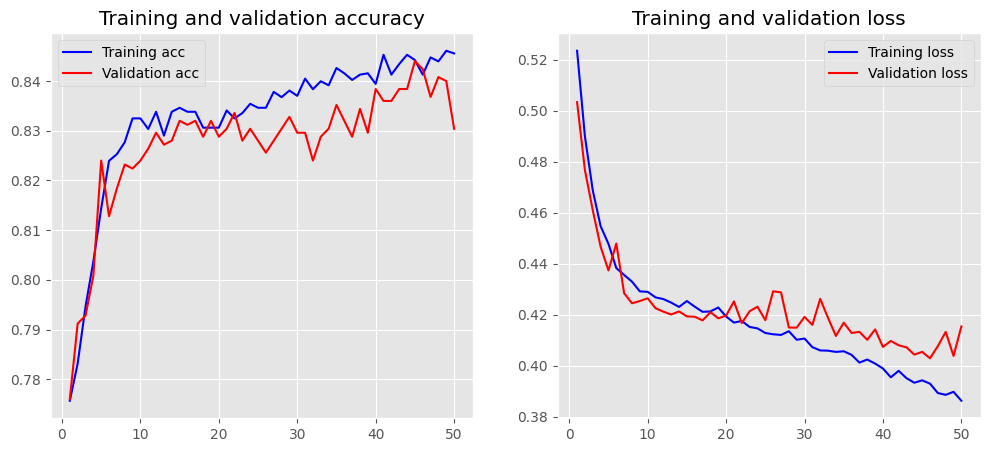

In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=10
)

_, train_accuracy = model.evaluate(X_train, y_train)
print(f'Training Accuracy: {train_accuracy:.4f}')
_, test_accuracy = model.evaluate(X_test, y_test)
print(f'Testing Accuracy: {test_accuracy:.4f}')
plot_history(history)

Das NN überfittet diesesmal nicht. Die Accuracy das Modell beträgt dann ca. 83-84% auf den Testdaten. Diese ist keine Verbesserung zum NN ohne vortranierter Schicht mit ca. 90%. Auf jeden Fall übersteigt sie die des naiven ML Modells mit 77,7% (siehe oben).

Als letzte Variante trainieren wir die Word Embeddings jetzt mit.

Der weitere Aufbau sowie das Trainieren des neuronalen Netzes bleibt wie gehabt.

In [ ]:
model = models.SequentEmbedding(
    input_dim=len(tokenizer.word_index) + 1,
    output_dim=50,ial()
model.add(layers.
    input_length=100,
    weights=[embedding_matrix],
    trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Epoch 1/50
375/375 [==============================] - 8s 18ms/step - loss: 0.4987 - accuracy: 0.7863 - val_loss: 0.4383 - val_accuracy: 0.8080
Epoch 2/50
375/375 [==============================] - 6s 16ms/step - loss: 0.3891 - accuracy: 0.8544 - val_loss: 0.3636 - val_accuracy: 0.8672
Epoch 3/50
375/375 [==============================] - 7s 18ms/step - loss: 0.3172 - accuracy: 0.8808 - val_loss: 0.3412 - val_accuracy: 0.8640
Epoch 4/50
375/375 [==============================] - 13s 34ms/step - loss: 0.2633 - accuracy: 0.9008 - val_loss: 0.3271 - val_accuracy: 0.8744
Epoch 5/50
375/375 [==============================] - 9s 23ms/step - loss: 0.2187 - accuracy: 0.9133 - val_loss: 0.3287 - val_accuracy: 0.8768
Epoch 6/50
375/375 [==============================] - 9s 23ms/step - loss: 0.1812 - accuracy: 0.9338 - val_loss: 0.3383 - val_accuracy: 0.8824
Epoch 7/50
375/375 [==============================] - 11s 29ms/step - loss: 0.1473 - accuracy: 0.9461 - val_loss: 0.3503 - val_accuracy: 0.87

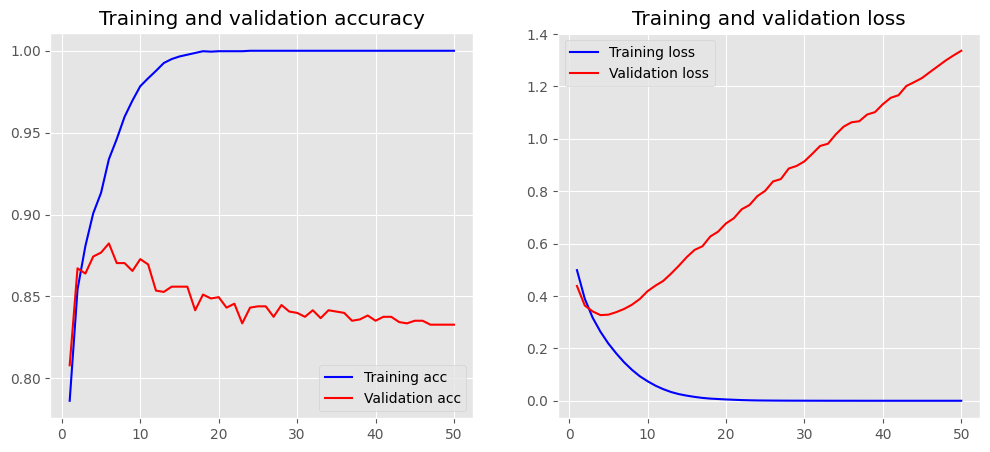

In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=10
)

_, train_accuracy = model.evaluate(X_train, y_train)
print(f'Training Accuracy: {train_accuracy:.4f}')
_, test_accuracy = model.evaluate(X_test, y_test)
print(f'Testing Accuracy: {test_accuracy:.4f}')
plot_history(history)

Das NN überfittet ab der 6. Epoche. Die Accuracy das Modell beträgt dann ca. 88% auf den Testdaten. Diese ist eine Verbesserung zum NN mit vortrainierter Schicht mit ca. 83-84%. Auf jeden Fall übersteigt sie die des naiven ML Modells mit 77,7% (siehe oben).